In [24]:
# library
import os
import re
import glob
import openpyxl
import numpy as np
import pandas as pd
import datetime as dt
from io import BytesIO
import matplotlib.pyplot as plt

# third-party
from fastapi import FastAPI, UploadFile, File, Form, HTTPException
from sqlalchemy import create_engine, text
from sqlalchemy.engine import Engine

### 01. import data

In [ ]:
df = pd.read_excel("data/01. movement-sheet-monthly-25.xls")
header_names = df.columns.tolist()
header_names = header_names + ["bulan"]
print(header_names)

['NO.', 'ACType', 'Reg No.', 'OPR', 'Flight Number Origin', 'Flight Number Dest', 'ATA', 'Block ON', 'Block OFF', 'ATD', 'Ground Time', 'ORG', 'DES', 'PS', 'Runway', 'Avio A', 'Avio D', 'Fstat', 'bulan']


In [ ]:
def get_header_with_bulan(file_path):
    df_header = pd.read_excel(file_path, header=0)
    header_names = df_header.columns.tolist() + ["bulan"]
    return header_names

def read_file(file_path):
    file_name = os.path.basename(file_path)
    month_num = int(file_name.split(".")[0])
    df = pd.read_excel(file_path, skiprows=1, header=None)
    df["bulan"] = month_num
    return df

def concat_data(folder_path):
    files = glob.glob(os.path.join(folder_path, "*.xls"))
    files.sort(key=lambda x: int(os.path.basename(x).split(".")[0]))
    
    if not files:
        print(f"Tidak ada file di folder {folder_path}")
        return pd.DataFrame(), []
    
    header_names = get_header_with_bulan(files[0])
    
    df_list = []
    for f in files:
        print(f"Processing: {os.path.basename(f)}")
        df_list.append(read_file(f))

    final_df = pd.concat(df_list, ignore_index=True)
    final_df.columns = header_names  # set header
    return final_df, header_names

final_df, header_names = concat_data("data")
final_df


Processing: 01. movement-sheet-monthly-25.xls
Processing: 02. movement-sheet-monthly-25.xls
Processing: 03. movement-sheet-monthly-25.xls
Processing: 04. movement-sheet-monthly-25.xls
Processing: 05. movement-sheet-monthly-25.xls
Processing: 06. movement-sheet-monthly-25.xls
Processing: 07. movement-sheet-monthly-25.xls


,NO.,ACType,Reg No.,OPR,Flight Number Origin,Flight Number Dest,ATA,Block ON,Block OFF,ATD,Ground Time,ORG,DES,PS,Runway,Avio A,Avio D,Fstat,bulan
0,1.0,B738,PKLKP,LNI,LNI681,LNI878,31/15:51,31/15:56,01/04:59,01/05:07,13:02:08,PKY,AMQ,018,28,0,0,NML,1
1,2.0,A320,PKAZQ,AWQ,AWQ327,AWQ320,01/00:03,01/00:07,01/05:03,01/05:13,4:56:00,KUL,KUL,A03,28,1,1,NML,1
2,3.0,A320,PKPWD,PAS,PAS212,PAS213,31/20:31,31/20:37,01/05:40,01/05:48,9:03:00,CGK,CGK,005,28,1,1,NML,1
3,4.0,A320,PKGLL,CTV,CTV695,CTV725,31/22:47,31/22:56,01/05:38,01/05:46,6:42:00,DPS,CGK,007,28,1,1,NML,1
4,5.0,B739,PKLHY,LNI,LNI983,LNI882,31/13:44,31/13:48,01/06:03,01/06:09,16:14:43,PKU,UPG,023,28,0,0,NML,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26439,4136.0,B738,PKGMA,GIA,GIA3304,GIA319,31/18:43,31/18:48,31/19:57,31/20:06,1:09:00,HLP,CGK,004,10,1,1,NML,7
26440,4137.0,A320,PKBLC,BTK,BTK6576,BTK6587,31/20:23,31/20:30,31/22:02,31/22:15,1:32:00,CGK,CGK,011,10,1,1,NML,7
26441,4138.0,A320,PKGLX,CTV,CTV435,CTV9484,31/19:26,31/19:30,31/20:20,31/20:30,0:50:00,BPN,BDJ,009,10,1,1,NML,7
26442,4139.0,A320,PKGLE,CTV,CTV724,CTV354,31/21:20,31/21:26,31/22:09,31/22:26,0:43:00,CGK,UPG,007,10,1,1,NML,7


In [38]:
# export
# df_all.to_csv('data_flight_raw.csv', index=False)
final_df.to_excel('data_flight_raw.xlsx', index=False)

### clean data

In [ ]:
# filtered all flight (data bird strike udh di remove)
a = pd.read_excel("data_flight_filtered.xlsx")
display(a.info())
a

In [ ]:
# buat tempat
kolom = [
    'tahun', 'tanggal', 'bulan', 'jam', 'waktu', 'cuaca',
    'jumlah burung pada titik x', 'titik', 'fase', 'remarks', 'strike'
]
df_baru = pd.DataFrame(columns=kolom)
df_baru

In [ ]:
# fungsi untuk menentukan waktu berdasarkan jam
def get_waktu(jam_str):
    try:
        jam_obj = datetime.strptime(jam_str, "%H:%M").time()
        if datetime.strptime("00:01", "%H:%M").time() <= jam_obj <= datetime.strptime("03:00", "%H:%M").time():
            return "Dini Hari"
        elif datetime.strptime("03:01", "%H:%M").time() <= jam_obj <= datetime.strptime("10:00", "%H:%M").time():
            return "Pagi"
        elif datetime.strptime("10:01", "%H:%M").time() <= jam_obj <= datetime.strptime("15:00", "%H:%M").time():
            return "Siang"
        elif datetime.strptime("15:01", "%H:%M").time() <= jam_obj <= datetime.strptime("18:00", "%H:%M").time():
            return "Sore"
        elif datetime.strptime("18:01", "%H:%M").time() <= jam_obj <= datetime.strptime("23:59", "%H:%M").time():
            return "Malam"
        else:
            return "-"
    except:
        return "-"

In [ ]:
# jadikan 2, data take off sama landing
# dan masukin ke tempatnya
# Loop per baris untuk ATA dan ATD
for _, row in a.iterrows():
    bulan = row['month']
    
    # Baris ATA (Landing)
    if isinstance(row['ATA'], str) and '/' in row['ATA']:
        tgl, jam = row['ATA'].split('/')
        waktu = get_waktu(jam)
        df_baru = pd.concat([df_baru, pd.DataFrame([{
            'tahun': 2025,
            'tanggal': int(tgl),
            'bulan': bulan,
            'jam': jam,
            'waktu': waktu,
            'cuaca': None,
            'jumlah burung pada titik x': None,
            'titik': None,
            'fase': 'Landing',
            'remarks': None,
            'strike': 0
        }])], ignore_index=True)

    # Baris ATD (Take Off)
    if isinstance(row['ATD'], str) and '/' in row['ATD']:
        tgl, jam = row['ATD'].split('/')
        waktu = get_waktu(jam)
        df_baru = pd.concat([df_baru, pd.DataFrame([{
            'tahun': 2025,
            'tanggal': int(tgl),
            'bulan': bulan,
            'jam': jam,
            'waktu': waktu,
            'cuaca': None,
            'jumlah burung pada titik x': None,
            'titik': None,
            'fase': 'Take Off',
            'remarks': None,
            'strike': 0
        }])], ignore_index=True)

# Lihat hasil
df_baru

### cuaca

In [ ]:
# import data cuaca
# pip install openmeteo-requests
# pip install requests-cache retry-requests numpy pandas
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": -7.38,
	"longitude": 112.7851,
	"start_date": "2025-01-01",
	"end_date": "2025-07-31",
	"hourly": "weather_code",
	"timezone": "auto",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_weather_code = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["weather_code"] = hourly_weather_code

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

### gabungin data_clean dan weather

In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Preprocessing hourly_dataframe (data 2) ---
# Pastikan kolom date dalam format datetime dan hilangkan timezone
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date']).dt.tz_localize(None)

# Buat kolom pecahan waktu: tahun, bulan, tanggal, jam dibulatkan ke bawah
hourly_dataframe['jam_cocok'] = hourly_dataframe['date'].dt.floor('H').dt.strftime('%H:%M')
hourly_dataframe['tahun'] = hourly_dataframe['date'].dt.year
hourly_dataframe['bulan'] = hourly_dataframe['date'].dt.month
hourly_dataframe['tanggal'] = hourly_dataframe['date'].dt.day

# --- Step 2: Preprocessing df_baru (data 1) ---
# Simpan jam asli
df_baru['jam_asli'] = df_baru['jam']

# Buat versi pembulatan jam hanya untuk pencocokan
df_baru['jam_cocok'] = pd.to_datetime(df_baru['jam'], format='%H:%M', errors='coerce').dt.floor('H').dt.strftime('%H:%M')

# --- Step 3: Gabungkan berdasarkan tahun, bulan, tanggal, dan jam_cocok ---
# Drop kolom cuaca lama
df_baru = df_baru.drop(columns='cuaca', errors='ignore')

# Merge
df_baru = df_baru.merge(
    hourly_dataframe[['tahun', 'bulan', 'tanggal', 'jam_cocok', 'weather_code']],
    left_on=['tahun', 'bulan', 'tanggal', 'jam_cocok'],
    right_on=['tahun', 'bulan', 'tanggal', 'jam_cocok'],
    how='left'
)

# --- Step 4: Mapping weather_code ke 4 kategori cuaca ---
def map_to_4_cuaca(code):
    if pd.isnull(code):
        return None
    code = int(code)
    if code in [0]:  # Cerah
        return "Cerah"
    elif code in [1, 2]:  # Cerah Berawan
        return "Cerah Berawan"
    elif code in [3, 45, 48]:  # Mendung
        return "Mendung"
    elif code in [51, 53, 55, 56, 57, 61, 63, 65, 66, 67, 71, 73, 75, 80, 81, 82, 95, 96, 99]:  # Hujan
        return "Hujan"
    else:
        return "Cerah Berawan"  # Default fallback

df_baru['cuaca'] = df_baru['weather_code'].apply(map_to_4_cuaca)

# Drop kolom tambahan
df_baru = df_baru.drop(columns=['jam_cocok', 'weather_code'])

# Kembalikan nama kolom jam seperti semula (kalau ingin)
df_baru = df_baru.rename(columns={'jam_asli': 'jam'})


In [ ]:
df_baru

In [ ]:
df_baru.to_excel("data_clean.xlsx", index=False)

### gabungin data birdstrike dan weather

In [ ]:
bb = pd.read_excel("data burung ga bersi.xlsx")
bb

In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Gabungkan tahun, bulan, tanggal dan jam pada bb menjadi kolom datetime ---
bb['jam'] = bb['jam'].astype(str)
bb['datetime'] = pd.to_datetime(
    bb['tahun'].astype(str) + '-' +
    bb['bulan'].astype(str).str.zfill(2) + '-' +
    bb['tanggal'].astype(str).str.zfill(2) + ' ' +
    bb['jam'].str[:2] + ':00:00'
)

# --- Step 2: Pastikan kolom 'date' di hourly_dataframe dalam format datetime tanpa timezone ---
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date']).dt.tz_localize(None)

# --- Step 3: Gabungkan berdasarkan waktu ---
bb = pd.merge(
    bb,
    hourly_dataframe.rename(columns={'date': 'datetime', 'weather_code': 'cuaca'}),
    on='datetime',
    how='left'
)

# --- Step 4: Mapping weather_code ke 4 kategori cuaca ---
def map_to_4_cuaca(code):
    if pd.isnull(code):
        return None
    code = int(code)
    if code in [0]:  # Cerah
        return "Cerah"
    elif code in [1, 2]:  # Cerah Berawan
        return "Cerah Berawan"
    elif code in [3, 45, 48]:  # Mendung
        return "Mendung"
    elif code in [51, 53, 55, 56, 57, 61, 63, 65, 66, 67, 71, 73, 75, 80, 81, 82, 95, 96, 99]:  # Hujan
        return "Hujan"
    else:
        return "Cerah Berawan"  # Default fallback

bb['cuaca'] = bb['cuaca'].apply(map_to_4_cuaca)

# --- Step 5: Drop kolom datetime jika tidak diperlukan ---
bb.drop(columns='datetime', inplace=True)

# --- Done ---



In [ ]:
bb.to_excel("data_clean_bb.xlsx", index=False)

### bootstrapping titik

In [3]:
b = pd.read_excel("data_buat_bootstrap.xlsx", sheet_name="frekuensi")
b

,Tanggal,Waktu,Titik 1,Titik 2,Titik 3,Titik 4,Titik 5,Titik 6,Titik 7,Titik 8
0,15 Juli,Pagi,27.0,121.0,17.0,113.0,243.0,12.0,63.0,49.0
1,15 Juli,Siang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15 Juli,Sore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18 Juli,Pagi,99.0,41.0,26.0,98.0,117.0,22.0,NaN,107.0
4,18 Juli,Siang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,18 Juli,Sore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,21 Juli,Pagi,42.0,NaN,NaN,52.0,118.0,2.0,6.0,13.0
7,21 Juli,Siang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,21 Juli,Sore,NaN,81.0,65.0,NaN,NaN,NaN,NaN,NaN
9,22 Juli,Pagi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
x = pd.read_excel("data_buat_bootstrap.xlsx", sheet_name="bootstrap")
x

,tahun,tanggal,bulan,jam,waktu,cuaca,jumlah burung pada titik x,titik,fase,strike
0,2025,1,1,18:33:00,Malam,Hujan,NaN,NaN,Landing,1
1,2025,6,1,18:17:00,Malam,Mendung,NaN,NaN,Landing,1
2,2025,9,2,16:10:00,Sore,Mendung,NaN,NaN,Landing,1
3,2025,21,2,10:18:00,Siang,Hujan,NaN,NaN,Take Off,1
4,2025,25,2,12:55:00,Siang,Hujan,NaN,NaN,Landing,1
...,...,...,...,...,...,...,...,...,...,...
52854,2025,8,7,07:01:00,Pagi,Cerah Berawan,NaN,NaN,Take Off,0
52855,2025,7,7,21:10:00,Malam,Mendung,NaN,NaN,Landing,0
52856,2025,8,7,07:05:00,Pagi,Cerah Berawan,NaN,NaN,Take Off,0
52857,2025,8,7,06:20:00,Pagi,Cerah Berawan,NaN,NaN,Landing,0


In [11]:
# Buat pool titik untuk strike 1 dan strike 0
def buat_pool(b):
    titik_cols = [col for col in b.columns if col.startswith("Titik")]
    
    pool = {}
    for waktu in b['Waktu'].unique():
        subset = b[b['Waktu'] == waktu]
        titik_tersedia = (
            subset[titik_cols]
            .stack()
            .dropna()
            .index.get_level_values(1)
            .unique()
            .tolist()
        )
        pool[waktu] = titik_tersedia
    
    # Pool keseluruhan (tanpa filter waktu)
    pool['ALL'] = (
        b[titik_cols]
        .stack()
        .dropna()
        .index.get_level_values(1)
        .unique()
        .tolist()
    )
    return pool

# Misalnya b_strike1 dan b_strike0 dari data b awal
b_strike1 = b.copy()  # nanti kalau punya filter khusus strike 1, dipakai di sini
b_strike0 = b.copy()  # nanti kalau punya filter khusus strike 0, dipakai di sini

pool_strike1 = buat_pool(b_strike1)
pool_strike0 = buat_pool(b_strike0)

def bootstrap_titik(row):
    # Pilih pool sesuai strike
    if row['strike'] == 1:
        pool = pool_strike1
    else:
        pool = pool_strike0
    
    # Ambil titik berdasarkan waktu
    titik_tersedia = pool.get(row['waktu'], [])
    if not titik_tersedia:  # kalau kosong, pakai pool ALL
        titik_tersedia = pool['ALL']
    
    if not titik_tersedia:
        return np.nan
    
    titik_pilihan = np.random.choice(titik_tersedia)
    return int(titik_pilihan.replace("Titik", "").strip())

# Terapkan bootstrap
x['titik'] = x.apply(bootstrap_titik, axis=1)


In [22]:
avg_per_titik = {
    1: 52.6666667,
    2: 88.14285714,
    3: 74,
    4: 76,
    5: 95.57142857,
    6: 12,
    7: 34.5,
    8: 38.8
}

x['jumlah burung pada titik x'] = x['titik'].map(avg_per_titik)

In [26]:
x.to_excel("data_hasil_bootstrap.xlsx", index=False)

In [23]:
x

,tahun,tanggal,bulan,jam,waktu,cuaca,jumlah burung pada titik x,titik,fase,strike
0,2025,1,1,18:33:00,Malam,Hujan,88.142857,2,Landing,1
1,2025,6,1,18:17:00,Malam,Mendung,52.666667,1,Landing,1
2,2025,9,2,16:10:00,Sore,Mendung,52.666667,1,Landing,1
3,2025,21,2,10:18:00,Siang,Hujan,95.571429,5,Take Off,1
4,2025,25,2,12:55:00,Siang,Hujan,88.142857,2,Landing,1
...,...,...,...,...,...,...,...,...,...,...
52854,2025,8,7,07:01:00,Pagi,Cerah Berawan,12.000000,6,Take Off,0
52855,2025,7,7,21:10:00,Malam,Mendung,76.000000,4,Landing,0
52856,2025,8,7,07:05:00,Pagi,Cerah Berawan,88.142857,2,Take Off,0
52857,2025,8,7,06:20:00,Pagi,Cerah Berawan,76.000000,4,Landing,0


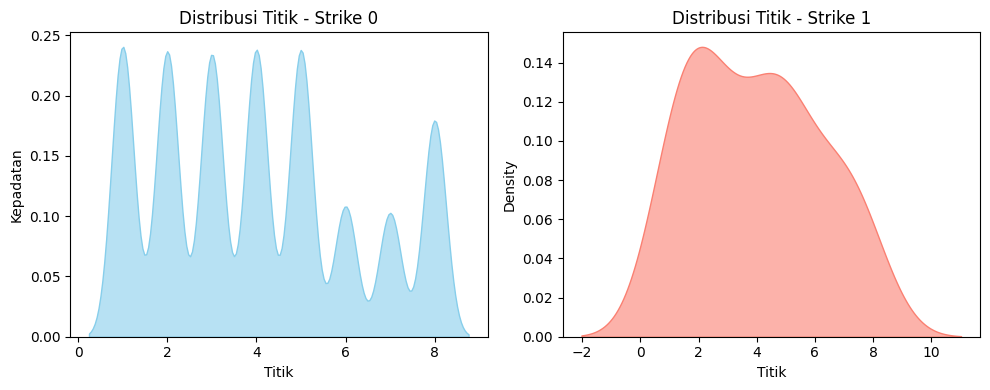

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# Plot strike 0
sns.kdeplot(
    x=x.loc[x['strike'] == 0, 'titik'],
    fill=True, color='skyblue', alpha=0.6,
    ax=axes[0]
)
axes[0].set_title('Distribusi Titik - Strike 0')
axes[0].set_xlabel('Titik')
axes[0].set_ylabel('Kepadatan')

# Plot strike 1
sns.kdeplot(
    x=x.loc[x['strike'] == 1, 'titik'],
    fill=True, color='salmon', alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('Distribusi Titik - Strike 1')
axes[1].set_xlabel('Titik')

plt.tight_layout()
plt.show()
